In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.linear_model import LogisticRegression
from mord import OrdinalRidge, LogisticAT, LogisticIT, LogisticSE, LAD
np.random.seed(1)
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_pickle('train_set.pickle')
train['filename'] = train['filename'].apply(lambda x: x.split('/')[-1])
train['features'] = train['features'].apply(lambda x: np.mean(x, axis=0))
train['age'] = train['age'].apply(lambda x: np.median(x))
train['gender'] = train['gender'].apply(lambda x: np.median(x))
labels = pd.read_csv('train.txt', header=None, sep='  ')
train = pd.merge(train, labels, how='inner', left_on='filename', right_on=0)
train = train.rename(columns={0: 'name', 1: "target"})
train.dropna(inplace=True)
for i in range(1024):
    train[i] = [x[i] for x in train['features']]
train.drop(['name', 'features'], axis=1, inplace=True)
train['emotion'] = list(map(lambda x: x.split('_')[0], train['filename']))
train['emotion'] = train['emotion'].apply(lambda x: (0 if x == 'neg' else (1 if x == 'neu' else (2 if x == 'pos' else x))))
train.reset_index(drop=True, inplace=True)
train

,filename,age,gender,target,0,1,2,3,4,5,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,emotion
0,pos_577.jpg,34.345988,0.025728,2,0.376063,0.037215,0.502219,0.116402,0.531689,0.114408,...,0.956416,0.259476,0.493424,0.266535,0.351016,0.320609,0.187088,0.117255,0.057350,2
1,pos_583.jpg,35.299664,0.968556,2,0.221193,0.228066,0.190070,0.415033,0.000000,0.068632,...,0.265605,0.013332,0.113176,0.095024,0.891857,0.016025,0.034990,0.048576,0.007375,2
2,pos_579.jpg,9.644070,0.122276,2,0.023657,0.000000,0.000000,0.139015,0.000000,0.214940,...,0.140065,0.233191,0.009372,0.379119,0.000000,0.000000,0.011037,0.243682,0.168824,2
3,pos_585.jpg,30.467837,0.447095,2,0.250920,0.038105,0.055551,0.252716,0.017855,0.102397,...,0.064782,0.105530,0.133086,0.149044,0.168625,0.042613,0.024562,0.059799,0.009473,2
4,pos_589.jpg,28.561078,0.826333,3,0.193709,0.541520,0.062039,0.002619,0.329195,0.282683,...,0.276172,0.033571,0.166043,0.014922,0.028219,0.079702,0.094622,0.279265,0.079119,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8454,neg_1089.jpg,25.249389,0.676684,2,0.049587,0.265649,0.000000,0.232259,0.000000,0.031788,...,0.026444,0.000000,0.010460,0.000000,1.807124,0.028352,0.238080,0.000000,0.000000,0
8455,neg_1090.jpg,34.037214,0.851188,1,0.062276,0.241120,0.145124,0.073871,0.016848,0.091469,...,0.107395,0.312324,0.003346,0.125467,0.258570,0.198946,0.110611,0.026392,0.099921,0
8456,neg_1760.jpg,29.390183,0.598478,2,0.111733,0.085126,0.020304,0.319245,0.000000,0.100706,...,0.033734,0.172429,0.015628,0.209838,0.117979,0.402255,0.016619,0.142459,0.061566,0
8457,neg_1092.jpg,36.238653,0.960967,1,0.043311,0.190464,0.070046,0.084310,0.048733,0.029670,...,0.080730,0.092045,0.040264,0.017730,0.313473,0.350807,0.103811,0.095807,0.021898,0


In [3]:
val = pd.read_pickle('val_set.pickle')
val['filename'] = val['filename'].apply(lambda x: x.split('/')[-1])
val['features'] = val['features'].apply(lambda x: np.mean(x, axis=0))
val['age'] = val['age'].apply(lambda x: np.median(x))
val['gender'] = val['gender'].apply(lambda x: np.median(x))
labels = pd.read_csv('validation.txt', header=None, sep='  ')
val = pd.merge(val, labels, how='inner', left_on='filename', right_on=0)
val = val.rename(columns={0: 'name', 1: "target"})
val.dropna(inplace=True)
for i in range(1024):
    val[i] = [x[i] for x in val['features']]
val.drop(['name', 'features'], axis=1, inplace=True)
val['emotion'] = list(map(lambda x: x.split('_')[0], val['filename']))
val['emotion'] = val['emotion'].apply(lambda x: (0 if x == 'neg' else (1 if x == 'neu' else (2 if x == 'pos' else x))))
val.reset_index(drop=True, inplace=True)
val

,filename,age,gender,target,0,1,2,3,4,5,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,emotion
0,pos_575.jpg,32.540987,0.702918,3,0.192024,0.247141,0.215001,0.025266,0.007561,0.128036,...,0.152416,0.085822,0.104665,0.122048,0.461803,0.071234,0.140374,0.107920,0.229319,2
1,pos_571.jpg,30.499367,0.537119,3,0.241812,0.139867,0.296436,0.822290,0.045836,0.066887,...,0.055932,0.099419,0.060477,0.351158,0.739378,0.005959,0.015202,0.045890,0.115706,2
2,pos_572.jpg,34.007962,0.344310,3,0.044327,0.000631,0.414382,0.122435,0.000000,0.272498,...,0.036678,0.258280,0.058381,0.364330,0.000000,0.302129,0.000000,0.522075,0.022810,2
3,pos_574.jpg,27.556911,0.913257,3,0.084930,0.900116,0.000000,0.000000,0.336989,0.012790,...,0.076154,0.020689,0.009018,0.043529,0.013384,1.270410,0.016811,0.000000,0.534931,2
4,pos_576.jpg,34.490304,0.901202,2,0.265636,0.390372,0.117766,0.256120,0.000000,0.219103,...,0.113120,0.125788,0.194172,0.308126,0.144336,0.151401,0.186623,0.049364,0.118183,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3747,neg_1076.jpg,32.542496,0.884925,2,0.102904,0.084249,0.040118,0.163923,0.003421,0.047426,...,0.119336,0.045490,0.103114,0.032927,0.020343,0.347514,0.022912,0.166659,0.038684,0
3748,neg_1071.jpg,31.486500,0.742181,2,0.052510,0.402606,0.015196,0.007053,0.125443,0.100014,...,0.216314,0.004413,0.055449,0.000000,0.127751,0.129013,0.048542,0.121859,0.033795,0
3749,neg_1078.jpg,30.142811,0.899529,2,0.108071,0.240999,0.054670,0.077519,0.022788,0.146925,...,0.065093,0.025963,0.001869,0.000000,0.081549,0.287423,0.154524,0.111062,0.018890,0
3750,neg_1077.jpg,35.505142,0.876111,2,0.035995,0.135388,0.019874,0.153930,0.013208,0.206492,...,0.231069,0.249328,0.011936,0.032921,0.229262,0.156046,0.009490,0.040021,0.172498,0


In [4]:
train['target']

0       2
1       2
2       2
3       2
4       3
       ..
8454    2
8455    1
8456    2
8457    1
8458    1
Name: target, Length: 8459, dtype: int64

In [5]:
import keras
early_stop = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

Using TensorFlow backend.


In [7]:
from sklearn.decomposition import PCA
train_set = train.drop(['filename', 'target', 'emotion'], axis=1)
val_set = val.drop(['filename', 'target', 'emotion'], axis=1)
# train_set = PCA(n_components=848).fit_transform(train_set)
# val_set = PCA(n_components=848).fit_transform(val_set)
train_set = np.expand_dims(train_set, axis=2)
val_set = np.expand_dims(val_set, axis=2)

In [8]:
val_set.shape

(3752, 1026, 1)

In [9]:
from keras.models import Model
from keras.layers import *

inp = Input(shape=(1026,1))
x = Dense(600, activation='tanh')(inp)
x = Conv1D(512, 3, padding='same', activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Flatten()(x)
x = Dense(200, activation='sigmoid')(x)
2
out1 = Dense(1, activation='linear', name='regression')(x)
out2 = Dense(3, activation='softmax', name='classification')(x)

model = Model(inp, [out1, out2])
model.compile(optimizer='adam', loss={'classification':'sparse_categorical_crossentropy', 'regression':'mse'}, 
              metrics={'classification':'accuracy', 'regression':'mse'})
model.fit(train_set, {'regression':train['target'], 'classification':train['emotion']}, epochs=100, batch_size=32,
          validation_data=[val_set, {'regression':val['target'], 'classification':val['emotion']}], callbacks=[early_stop])

Train on 8459 samples, validate on 3752 samples
Epoch 1/100
8459/8459 [==============================] - 633s 75ms/step - loss: 1.9823 - regression_loss: 1.0372 - classification_loss: 0.9438 - regression_mse: 1.0382 - classification_accuracy: 0.5341 - val_loss: 1.4702 - val_regression_loss: 0.6810 - val_classification_loss: 0.7848 - val_regression_mse: 0.6852 - val_classification_accuracy: 0.6687
Epoch 2/100
8459/8459 [==============================] - 632s 75ms/step - loss: 1.4846 - regression_loss: 0.7532 - classification_loss: 0.7322 - regression_mse: 0.7531 - classification_accuracy: 0.6715 - val_loss: 1.4139 - val_regression_loss: 0.6721 - val_classification_loss: 0.7371 - val_regression_mse: 0.6761 - val_classification_accuracy: 0.6780
Epoch 3/100
8459/8459 [==============================] - 624s 74ms/step - loss: 1.3669 - regression_loss: 0.7003 - classification_loss: 0.6665 - regression_mse: 0.7008 - classification_accuracy: 0.6959 - val_loss: 1.3773 - val_regression_loss: 0.64

In [10]:
print(classification_report(train['emotion'], [np.argmax(x) for x in model.predict(train_set)[1]]))
print(classification_report(val['emotion'], [np.argmax(x) for x in model.predict(val_set)[1]]))
from sklearn.metrics import mean_squared_error
print(mean_squared_error(train['target'], model.predict(train_set)[0]))
print(mean_squared_error(val['target'], model.predict(val_set)[0]))

              precision    recall  f1-score   support

           0       0.74      0.45      0.56      2226
           1       0.64      0.65      0.65      2635
           2       0.75      0.92      0.82      3598

    accuracy                           0.71      8459
   macro avg       0.71      0.67      0.68      8459
weighted avg       0.71      0.71      0.70      8459

              precision    recall  f1-score   support

           0       0.70      0.40      0.51      1060
           1       0.59      0.65      0.62      1128
           2       0.73      0.88      0.80      1564

    accuracy                           0.68      3752
   macro avg       0.67      0.65      0.64      3752
weighted avg       0.68      0.68      0.66      3752

0.6448125442293355
0.651296800923749


In [32]:
from sklearn.decomposition import PCA
train_set = train.drop(['filename', 'target', 'emotion'], axis=1)
val_set = val.drop(['filename', 'target', 'emotion'], axis=1)
# train_set = PCA(n_components=848).fit_transform(train_set)
# val_set = PCA(n_components=848).fit_transform(val_set)
train_set = np.expand_dims(train_set, axis=2)
val_set = np.expand_dims(val_set, axis=2)

In [33]:
inp = Input(shape=(1026,1))
x = Dense(300, activation='tanh')(inp)
x = Conv1D(512, 3, padding='same', activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(256, 2, padding='same', activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = Dense(100, activation='sigmoid')(x)

out1 = Dense(1, activation='linear', name='regression')(x)
out2 = Dense(3, activation='softmax', name='classification')(x)

model = Model(inp, [out1, out2])
model.compile(optimizer='adam', loss={'classification':'sparse_categorical_crossentropy', 'regression':'mse'}, 
              metrics={'classification':'accuracy', 'regression':'mse'})
model.fit(train_set, {'regression':train['target'], 'classification':train['emotion']}, epochs=100, batch_size=32,
          validation_data=[val_set, {'regression':val['target'], 'classification':val['emotion']}], callbacks=[early_stop])

Train on 8459 samples, validate on 3752 samples
Epoch 1/100
8459/8459 [==============================] - 363s 43ms/step - loss: 1.9043 - regression_loss: 0.9421 - classification_loss: 0.9599 - regression_mse: 0.9434 - classification_accuracy: 0.5245 - val_loss: 1.5394 - val_regression_loss: 0.7271 - val_classification_loss: 0.8091 - val_regression_mse: 0.7310 - val_classification_accuracy: 0.6301
Epoch 2/100
8459/8459 [==============================] - 320s 38ms/step - loss: 1.4605 - regression_loss: 0.7260 - classification_loss: 0.7343 - regression_mse: 0.7262 - classification_accuracy: 0.6664 - val_loss: 1.4281 - val_regression_loss: 0.6613 - val_classification_loss: 0.7627 - val_regression_mse: 0.6653 - val_classification_accuracy: 0.6580
Epoch 3/100
8459/8459 [==============================] - 299s 35ms/step - loss: 1.3425 - regression_loss: 0.6809 - classification_loss: 0.6603 - regression_mse: 0.6815 - classification_accuracy: 0.6984 - val_loss: 1.3949 - val_regression_loss: 0.68

In [34]:
print(classification_report(train['emotion'], [np.argmax(x) for x in model.predict(train_set)[1]]))
print(classification_report(val['emotion'], [np.argmax(x) for x in model.predict(val_set)[1]]))
from sklearn.metrics import mean_squared_error
print(mean_squared_error(train['target'], model.predict(train_set)[0]))
print(mean_squared_error(val['target'], model.predict(val_set)[0]))

              precision    recall  f1-score   support

           0       0.62      0.73      0.67      2226
           1       0.70      0.58      0.63      2635
           2       0.85      0.87      0.86      3598

    accuracy                           0.74      8459
   macro avg       0.72      0.72      0.72      8459
weighted avg       0.74      0.74      0.74      8459

              precision    recall  f1-score   support

           0       0.59      0.65      0.62      1060
           1       0.60      0.51      0.55      1128
           2       0.80      0.83      0.82      1564

    accuracy                           0.68      3752
   macro avg       0.66      0.66      0.66      3752
weighted avg       0.68      0.68      0.68      3752

0.6213526113477423
0.6873641540613148


In [56]:
from sklearn.decomposition import PCA
train_set = train.drop(['filename', 'target', 'emotion'], axis=1)
val_set = val.drop(['filename', 'target', 'emotion'], axis=1)
# train_set = PCA(n_components=848).fit_transform(train_set)
# val_set = PCA(n_components=848).fit_transform(val_set)
train_set = np.expand_dims(train_set, axis=2)
val_set = np.expand_dims(val_set, axis=2)

In [57]:
inp = Input(shape=(1026,1))
x = Dense(600, activation='tanh')(inp)
x = Conv1D(512, 3, padding='same', activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(256, 2, padding='same', activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 2, padding='same', activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = Dense(100, activation='sigmoid')(x)

out1 = Dense(1, activation='linear', name='regression')(x)
out2 = Dense(3, activation='softmax', name='classification')(x)

model = Model(inp, [out1, out2])
model.compile(optimizer='adam', loss={'classification':'sparse_categorical_crossentropy', 'regression':'mse'}, 
              metrics={'classification':'accuracy', 'regression':'mse'})
model.fit(train_set, {'regression':train['target'], 'classification':train['emotion']}, epochs=100, batch_size=32,
          validation_data=[val_set, {'regression':val['target'], 'classification':val['emotion']}], callbacks=[early_stop])

Train on 8459 samples, validate on 3752 samples
Epoch 1/100
8459/8459 [==============================] - 398s 47ms/step - loss: 1.8562 - regression_loss: 0.8327 - classification_loss: 1.0218 - regression_mse: 0.8338 - classification_accuracy: 0.4744 - val_loss: 1.7061 - val_regression_loss: 0.7578 - val_classification_loss: 0.9446 - val_regression_mse: 0.7625 - val_classification_accuracy: 0.5229
Epoch 2/100
8459/8459 [==============================] - 400s 47ms/step - loss: 1.6181 - regression_loss: 0.7768 - classification_loss: 0.8422 - regression_mse: 0.7759 - classification_accuracy: 0.6133 - val_loss: 1.5189 - val_regression_loss: 0.7056 - val_classification_loss: 0.8085 - val_regression_mse: 0.7094 - val_classification_accuracy: 0.6325
Epoch 3/100
8459/8459 [==============================] - 409s 48ms/step - loss: 1.4960 - regression_loss: 0.7360 - classification_loss: 0.7606 - regression_mse: 0.7361 - classification_accuracy: 0.6494 - val_loss: 1.4482 - val_regression_loss: 0.66

In [58]:
print(classification_report(train['emotion'], [np.argmax(x) for x in model.predict(train_set)[1]]))
print(classification_report(val['emotion'], [np.argmax(x) for x in model.predict(val_set)[1]]))
from sklearn.metrics import mean_squared_error
print(mean_squared_error(train['target'], model.predict(train_set)[0]))
print(mean_squared_error(val['target'], model.predict(val_set)[0]))

              precision    recall  f1-score   support

           0       0.59      0.61      0.60      2226
           1       0.63      0.54      0.58      2635
           2       0.78      0.84      0.81      3598

    accuracy                           0.69      8459
   macro avg       0.67      0.66      0.66      8459
weighted avg       0.68      0.69      0.68      8459

              precision    recall  f1-score   support

           0       0.56      0.53      0.55      1060
           1       0.57      0.51      0.54      1128
           2       0.74      0.82      0.77      1564

    accuracy                           0.64      3752
   macro avg       0.62      0.62      0.62      3752
weighted avg       0.64      0.64      0.64      3752

0.6864446095890525
0.6728663010952861


In [16]:
model.evaluate(val_set, {'regression':val['target'], 'classification':val['emotion']})

3752/3752 [==============================] - 53s 14ms/step


[1.4182921396389698,
 0.6913327574729919,
 0.7219201326370239,
 0.6956148743629456,
 0.6775053143501282]

In [17]:
model.metrics_names

['loss',
 'regression_loss',
 'classification_loss',
 'regression_mse',
 'classification_accuracy']

In [6]:
import cv2
import glob
from tqdm import tqdm_notebook
ims = glob.glob('GroupCohesion/train/*')
df = pd.DataFrame()
df['img'] = 0
for i in tqdm_notebook(range(len(ims))):
    df.loc[i] = [cv2.resize(cv2.cvtColor(cv2.imread(ims[i]), cv2.COLOR_BGR2RGB), (640,360), interpolation=cv2.INTER_CUBIC)]
df

,img
0,"[[[21, 3, 20], [15, 1, 13], [15, 1, 11], [22, ..."
1,"[[[206, 210, 213], [206, 210, 213], [206, 210,..."
2,"[[[209, 197, 179], [228, 216, 199], [228, 216,..."
3,"[[[0, 0, 0], [13, 10, 9], [31, 27, 24], [16, 1..."
4,"[[[249, 245, 242], [249, 245, 242], [248, 244,..."
...,...
9295,"[[[118, 119, 121], [106, 107, 109], [22, 22, 2..."
9296,"[[[222, 251, 249], [207, 236, 234], [75, 104, ..."
9297,"[[[94, 73, 52], [93, 72, 51], [162, 141, 122],..."
9298,"[[[190, 192, 189], [190, 192, 189], [190, 192,..."


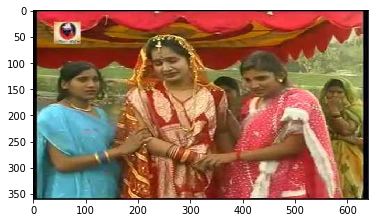

In [7]:
plt.imshow(df['img'][0])

In [8]:
ims[0].split('_')[1]

'1.jpg'

In [9]:
df['filename'] = [x.split('_')[0][-3:]+'_'+x.split('_')[1] for x in ims]
labels = pd.read_csv('train.txt', header=None, sep='  ')
train = pd.merge(df, labels, left_on='filename', right_on=0)
train.drop(0, axis=1, inplace=True)
train['filename'] = train['filename'].apply(lambda x: x.split('_')[0])
train['filename'] = train['filename'].apply(lambda x: (0 if x == 'neg' else (1 if x == 'neu' else (2 if x == 'pos' else x))))
train

,img,filename,1
0,"[[[21, 3, 20], [15, 1, 13], [15, 1, 11], [22, ...",0,3
1,"[[[206, 210, 213], [206, 210, 213], [206, 210,...",0,1
2,"[[[209, 197, 179], [228, 216, 199], [228, 216,...",0,3
3,"[[[0, 0, 0], [13, 10, 9], [31, 27, 24], [16, 1...",0,2
4,"[[[249, 245, 242], [249, 245, 242], [248, 244,...",0,2
...,...,...,...
9295,"[[[118, 119, 121], [106, 107, 109], [22, 22, 2...",2,2
9296,"[[[222, 251, 249], [207, 236, 234], [75, 104, ...",2,2
9297,"[[[94, 73, 52], [93, 72, 51], [162, 141, 122],...",2,2
9298,"[[[190, 192, 189], [190, 192, 189], [190, 192,...",2,2


In [10]:
ims = glob.glob('GroupCohesion/val/*')
d = pd.DataFrame()
d['img'] = 0
for i in tqdm_notebook(range(len(ims))):
    d.loc[i] = [cv2.resize(cv2.cvtColor(cv2.imread(ims[i]), cv2.COLOR_BGR2RGB), (640,360), interpolation=cv2.INTER_CUBIC)]
d

,img
0,"[[[0, 0, 2], [0, 0, 2], [0, 0, 2], [0, 0, 2], ..."
1,"[[[88, 67, 50], [88, 67, 50], [85, 64, 47], [8..."
2,"[[[65, 74, 47], [82, 90, 65], [123, 131, 108],..."
3,"[[[183, 193, 185], [190, 199, 193], [208, 218,..."
4,"[[[33, 36, 17], [28, 31, 14], [22, 24, 11], [1..."
...,...
4239,"[[[138, 133, 140], [138, 133, 140], [138, 133,..."
4240,"[[[62, 33, 27], [62, 33, 27], [62, 33, 27], [6..."
4241,"[[[196, 185, 165], [196, 185, 165], [195, 184,..."
4242,"[[[82, 72, 62], [105, 95, 85], [110, 100, 90],..."


In [11]:
d['filename'] = [x.split('_')[0][-3:]+'_'+x.split('_')[1] for x in ims]
labels = pd.read_csv('validation.txt', header=None, sep='  ')
val = pd.merge(d, labels, left_on='filename', right_on=0)
val.drop(0, axis=1, inplace=True)
val['filename'] = val['filename'].apply(lambda x: x.split('_')[0])
val['filename'] = val['filename'].apply(lambda x: (0 if x == 'neg' else (1 if x == 'neu' else (2 if x == 'pos' else x))))
val

,img,filename,1
0,"[[[0, 0, 2], [0, 0, 2], [0, 0, 2], [0, 0, 2], ...",0,2
1,"[[[88, 67, 50], [88, 67, 50], [85, 64, 47], [8...",0,0
2,"[[[65, 74, 47], [82, 90, 65], [123, 131, 108],...",0,1
3,"[[[183, 193, 185], [190, 199, 193], [208, 218,...",0,1
4,"[[[33, 36, 17], [28, 31, 14], [22, 24, 11], [1...",0,2
...,...,...,...
4239,"[[[138, 133, 140], [138, 133, 140], [138, 133,...",2,3
4240,"[[[62, 33, 27], [62, 33, 27], [62, 33, 27], [6...",2,3
4241,"[[[196, 185, 165], [196, 185, 165], [195, 184,...",2,3
4242,"[[[82, 72, 62], [105, 95, 85], [110, 100, 90],...",2,3


In [12]:
train_images = np.zeros((len(train), 640, 360), dtype=float)
val_images = np.zeros((len(val), 640, 360), dtype=float)

In [13]:
val_images.shape

(4244, 640, 360)

In [14]:
from keras.models import Model, Sequential
from keras.layers import *
inp = Input(shape=(640,360))
x = Dense(600, activation='tanh')(inp)
x = Conv1D(512, 3, padding='same', activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Flatten()(x)
x = Dense(200, activation='sigmoid')(x)

out1 = Dense(1, activation='linear', name='regression')(x)
out2 = Dense(3, activation='softmax', name='classification')(x)

model = Model(inp, [out1, out2])
model.compile(optimizer='adam', loss={'classification':'sparse_categorical_crossentropy', 'regression':'mse'}, 
              metrics={'classification':'accuracy', 'regression':'mse'})
model.fit(train_images, {'regression':train[1], 'classification':train['filename']}, epochs=100, batch_size=64,
         validation_data=[val_images, {'regression':val[1], 'classification':val['filename']}], callbacks=[early_stop])

Train on 9300 samples, validate on 4244 samples
Epoch 1/100
9300/9300 [==============================] - 511s 55ms/step - loss: 2.2315 - regression_loss: 1.1398 - classification_loss: 1.0897 - regression_mse: 1.1420 - classification_accuracy: 0.4109 - val_loss: 1.9897 - val_regression_loss: 0.9004 - val_classification_loss: 1.0896 - val_regression_mse: 0.8977 - val_classification_accuracy: 0.4008
Epoch 2/100
9300/9300 [==============================] - 475s 51ms/step - loss: 1.9226 - regression_loss: 0.8358 - classification_loss: 1.0866 - regression_mse: 0.8358 - classification_accuracy: 0.4049 - val_loss: 1.9891 - val_regression_loss: 0.8977 - val_classification_loss: 1.0902 - val_regression_mse: 0.8958 - val_classification_accuracy: 0.4008
Epoch 3/100
9300/9300 [==============================] - 504s 54ms/step - loss: 1.9229 - regression_loss: 0.8354 - classification_loss: 1.0867 - regression_mse: 0.8366 - classification_accuracy: 0.4083 - val_loss: 2.0079 - val_regression_loss: 0.90

In [15]:
model.evaluate(val_images, {'regression':val[1], 'classification':val['filename']})

4244/4244 [==============================] - 51s 12ms/step


[1.9837380877988278,
 0.896369993686676,
 1.0874040126800537,
 0.8958523869514465,
 0.4008011221885681]

In [ ]:
train.drop(['emotion', 'age'], axis=1, inplace=True)
val.drop(['emotion', 'age'], axis=1, inplace=True)

In [ ]:
import pickle
with open('train.pickle', 'wb') as f:
    pickle.dump(train, f)
with open('val.pickle', 'wb') as v:
    pickle.dump(val, v)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
n_components = 32
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)

In [ ]:
from catboost import CatBoostClassifier
cb = Pipeline(steps=[('pca', pca), ('classifier', CatBoostClassifier(depth=3, n_estimators=10000, learning_rate=0.01, loss_function='MultiClass'))])
cb.fit(train.drop(['filename', 'target'], axis=1), train['target'])

In [ ]:
from sklearn.metrics import classification_report
print('TRAIN:\n',classification_report(train['target'], cb.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION:\n',classification_report(val['target'], cb.predict(val.drop(['filename', 'target'], axis=1))))
print('TRAIN MSE: ', mean_squared_error(train['target'], cb.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION MSE: ', mean_squared_error(val['target'], cb.predict(val.drop(['filename', 'target'], axis=1))))

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = Pipeline(steps=[('pca', pca), ('classifier', LogisticRegression(C=7))])
logreg.fit(train.drop(['filename', 'target'], axis=1), train['target'])

In [ ]:
print('TRAIN:\n',classification_report(train['target'], logreg.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION:\n',classification_report(val['target'], logreg.predict(val.drop(['filename', 'target'], axis=1))))
print('TRAIN MSE: ', mean_squared_error(train['target'], logreg.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logreg.predict(val.drop(['filename', 'target'], axis=1))))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.drop(['filename', 'target'], axis=1))
val_scaled = scaler.transform(val.drop(['filename', 'target'], axis=1))

In [ ]:
logreg.fit(train_scaled, train['target'])

In [ ]:
print('TRAIN:\n',classification_report(train['target'], logreg.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logreg.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logreg.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logreg.predict(val_scaled)))

In [ ]:
import matplotlib
matplotlib.__version__

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
params = {'classifier__C':range(0,31),
         'classifier__max_iter':[100, 200, 500, 1000],
          'classifier__penalty':['l2', 'l1'],
         'pca__n_components':[16,32,64,128,256],
         'pca__whiten':[True, False]}
fold = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(logreg, param_grid=params, n_jobs=-1, cv=fold, scoring='neg_root_mean_squared_error', verbose=1)
grid.fit(train_scaled, train['target'])

In [ ]:
grid.best_params_

In [ ]:
logreg = Pipeline(steps=[('pca', PCA(n_components=16, whiten=True)), ('classifier', LogisticRegression(C=19, max_iter=1000))])
logreg.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], logreg.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logreg.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logreg.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logreg.predict(val_scaled)))

In [ ]:
from mord import OrdinalRidge, LogisticAT, LogisticIT, LogisticSE
ord_reg = Pipeline(steps=[('pca', pca), ('classifier', OrdinalRidge(alpha=25))])
ord_reg.fit(train_scaled, train['target'])

In [ ]:
print('TRAIN:\n',classification_report(train['target'], ord_reg.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], ord_reg.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], ord_reg.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], ord_reg.predict(val_scaled)))

In [ ]:
ord_reg.fit(train.drop(['filename', 'target'], axis=1), train['target'])
print('TRAIN:\n',classification_report(train['target'], ord_reg.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION:\n',classification_report(val['target'], ord_reg.predict(val.drop(['filename', 'target'], axis=1))))
print('TRAIN MSE: ', mean_squared_error(train['target'], ord_reg.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION MSE: ', mean_squared_error(val['target'], ord_reg.predict(val.drop(['filename', 'target'], axis=1))))

In [ ]:
ord_reg = OrdinalRidge(alpha=0)
ord_reg.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], ord_reg.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], ord_reg.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], ord_reg.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], ord_reg.predict(val_scaled)))

In [ ]:
logat = Pipeline(steps=[('pca', pca), ('classifier', LogisticAT(alpha=2))])
logat.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], logat.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logat.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logat.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logat.predict(val_scaled)))

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
params = {'classifier__alpha':range(0,31),
         'classifier__max_iter':[1000, 10000, 100000],
         'pca__n_components':[16,32,64,128,256],
         'pca__whiten':[True, False]}
fold = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(logat, param_grid=params, n_jobs=-1, cv=fold, scoring='neg_root_mean_squared_error', verbose=1)
grid.fit(train_scaled, train['target'])

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

In [ ]:
logat = Pipeline(steps=[('pca', PCA(n_components=256, whiten=False)), ('classifier', LogisticAT(alpha=20, max_iter=1000))])
logat.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], logat.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logat.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logat.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logat.predict(val_scaled)))

In [ ]:
logat = LogisticAT(alpha=0)
logat.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], logat.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logat.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logat.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logat.predict(val_scaled)))

In [ ]:
logit = LogisticIT(alpha=1)
logit.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], logit.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logit.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logit.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logit.predict(val_scaled)))

In [ ]:
logit = LogisticIT(alpha=0)
logit.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], logit.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logit.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logit.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logit.predict(val_scaled)))

In [ ]:
logse = LogisticSE(alpha=0)
logse.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], logse.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logse.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logse.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logse.predict(val_scaled)))

In [ ]:
logse = Pipeline(steps=[('pca', PCA(n_components=16)), ('classifier', LogisticSE(alpha=13))])
logse.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], logse.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logse.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], logse.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logse.predict(val_scaled)))

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
params = {'classifier__alpha':range(0,31),
         'classifier__max_iter':[50000, 10000, 500000, 100000, 200000, 1000000],
         'pca__n_components':[16,32,64,128,256],
         'pca__whiten':[True, False]}
fold = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(logse, param_grid=params, n_jobs=-1, cv=fold, scoring='neg_mean_squared_error', verbose=1)
grid.fit(train_scaled, train['target'])

In [ ]:
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
logse =  Pipeline(steps=[('pca', PCA(n_components=256)), ('classifier', LogisticSE(alpha=28, max_iter=1000000))])
logse.fit(train_scaled, train['target'])
# print('TRAIN:\n',classification_report(train['target'], logse.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], logse.predict(val_scaled)))
# print('TRAIN MSE: ', mean_squared_error(train['target'], logse.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], logse.predict(val_scaled)))

In [ ]:
mul_lr = LogisticRegression(multi_class='multinomial',fit_intercept=True)
mul_lr.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], mul_lr.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], mul_lr.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], mul_lr.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], mul_lr.predict(val_scaled)))

In [ ]:
lad = LAD(C=7)
lad.fit(train_scaled, train['target'])
print('TRAIN:\n',classification_report(train['target'], lad.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], lad.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], lad.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], lad.predict(val_scaled)))

In [ ]:
from sklearn.base import clone


class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y, sample_w):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y,  sample_weight=sample_w)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [ ]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(train['target']),
                                             train['target']))
w_array = np.ones(train['target'].shape[0], dtype = 'float')
for i, v in enumerate(train['target']):
    w_array[i] = class_weights[v-1]
w_array.shape

In [ ]:
%%time
ord_clf = OrdinalClassifier(CatBoostClassifier(depth=3, n_estimators=10000,
                                               learning_rate=0.01, verbose=False, loss_function='MultiClass'))
ord_clf.fit(train.drop(['filename', 'target'], axis=1), train['target'], w_array)
print('TRAIN:\n',classification_report(train['target'], ord_clf.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION:\n',classification_report(val['target'], ord_clf.predict(val.drop(['filename', 'target'], axis=1))))
print('TRAIN MSE: ', mean_squared_error(train['target'], ord_clf.predict(train.drop(['filename', 'target'], axis=1))))
print('VALIDATION MSE: ', mean_squared_error(val['target'], ord_clf.predict(val.drop(['filename', 'target'], axis=1))))

In [ ]:
%%time
ord_clf = OrdinalClassifier(LogisticSE(alpha=2))
ord_clf.fit(train_scaled, train['target'], w_array)
print('TRAIN:\n',classification_report(train['target'], ord_clf.predict(train_scaled)))
print('VALIDATION:\n',classification_report(val['target'], ord_clf.predict(val_scaled)))
print('TRAIN MSE: ', mean_squared_error(train['target'], ord_clf.predict(train_scaled)))
print('VALIDATION MSE: ', mean_squared_error(val['target'], ord_clf.predict(val_scaled)))

In [ ]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(random_state=37, n_components=3)
X_tsne = tsne.fit_transform(train_scaled)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)
s = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=train['target'])
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.set_zlabel('t-SNE dimension 3')
fig.colorbar(s)
plt.show()